# BASELINE ATTEMPT: Only hand engineered features

In [1]:
# setup
from modules.data_loader import *
from modules.feature_engineering import *
from modules.visualizer import *

In [2]:
# #run if you dont have the data downloaded this is a few gb of data
# import kagglehub
# path = kagglehub.dataset_download("ealtman2019/ibm-transactions-for-anti-money-laundering-aml")
# print("Path to dataset files:", path)

## 1. Create our dataframes from raw data

In [3]:
dataset_name = "HI-Small"

print(f"Loading {dataset_name}...\n")
trans_df = load_transactions(dataset_size=dataset_name)
accounts_df = load_accounts(dataset_size=dataset_name)
# patterns_df = load_patterns(dataset_size=dataset_name)


Loading HI-Small...


Loading transactions from: /home/linch/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8/HI-Small_Trans.csv
File size: 453.6 MB

Loaded 5,078,345 transactions
Date range: 2022-09-01 00:00:00 to 2022-09-18 16:18:00
Laundering transactions: 5,177 (0.102%)

Loading accounts from: /home/linch/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8/HI-Small_accounts.csv

Loaded 518,581 accounts from 30470 banks


## 2. Feature engineering - For this notebook, we calculate several different statistics to do manual feature engineering

In [4]:
# convert all currencies to USD for normaliztion

trans_df = convert_currency_to_USD(trans_df)

In [5]:
# Successfully verified that currency conversion is within margin of error

# trans_df_verification = trans_df.copy()
# trans_df_verification["diff"] = trans_df["amount_received"] - trans_df["amount_paid"]
# show = ["amount_received", "receiving_currency", "amount_paid", "payment_currency", "diff"]
# print(trans_df_verification.loc[trans_df_verification['diff'] > 50, show])

In [6]:
# compute sinusoidal temporal encodings and normalized unix timestamp

trans_df = temporal_encoding(trans_df)
print(trans_df['hour_sin'].max())
print(trans_df['hour_sin'].min())
print(trans_df['hour_cos'].max())
print(trans_df['hour_cos'].min())
print(trans_df['time_normalized'].max())
print(trans_df['time_normalized'].min())
print(trans_df['time_normalized'].mean())

1.0
-1.0
1.0
-1.0
4.282624796869565
-1.3776303742917988
1.2980283339374991e-13


In [7]:
# give each currency and payment method a unique integer ID

trans_df = encode_currency_ids(trans_df)
trans_df = encode_payment_format_ids(trans_df)
print(trans_df['receiving_currency_id'])

0          12
1          12
2          12
3          12
4          12
           ..
5078340     1
5078341     1
5078342     1
5078343     1
5078344     1
Name: receiving_currency_id, Length: 5078345, dtype: category
Categories (15, int64): [0, 1, 3, 4, ..., 2, 8, 9, 10]


In [8]:
# give each account a unique integer ID

trans_df, account_to_id, id_to_account = encode_account_ids(trans_df)
print(max(trans_df['to_account_id'].max(), trans_df['from_account_id'].max()))
print(len(accounts_df))
print(len(accounts_df['account_id'].unique()))

# When working with transactions df, we see that only 515079 + 1 = 515080 accounts appear. This means only 515800 accounts have transacted. We will ignore accounts with no transactions.
# There are 518581 rows in the accounts df, we see there are 518581 rows. However there are only 518573 unique account numbers, which corroborates with the datacard on kaggle. This is likely because there are a few accounts that have different values for bank but share the same account id. We will treat them as the same account for now as we are ignoring the bank data.

515079
518581
518573


## 3. Temporal train/test split and account statistics

In [9]:
# split data temporally: first 80% for training, last 20% for testing

train_df, test_df = temporal_train_test_split(trans_df, train_ratio=0.8)

TEMPORAL TRAIN/TEST SPLIT

Train Set:
  Date range: 2022-09-01 00:00:00 to 2022-09-08 16:12:00
  Transactions: 4,062,676
  Laundering: 3,380 (0.083%)

Test Set:
  Date range: 2022-09-08 16:12:00 to 2022-09-18 16:18:00
  Transactions: 1,015,669
  Laundering: 1,797 (0.177%)


In [ ]:
# Compute account statistics for training set
# This adds 16 features per transaction based on account behavior
# In real (non deep learning) rule-based systems we are simulating for the baseline, account information is a part of the evaluation metric
# Hence, as a stopgap, we add information about the accounts that real rule-based systems use
# For graph based approaches, we encode this information in the account nodes

# for each source and destination account involved in the transaction, we add the following data to the transaction:
# 1. Average transactions per day (log and z-score normalized)
# 2. Mean amount transacted (log and z-score normalized)
# 3. Stddev of amounts transacted (log and z-score normalized)
# 4. Number of unique transaction partners (log and z-score normalized)
# 5. Diversity score of transaction partners (from 0 to 1)
# 6. Days between first and last transaction (z-score normalized)
# 7. Whether this is the first transaction (boolean flags)
# 8. Total transaction value in time frame (z-score normalized)

# There are a total of 8 features, thus 16 features are added to each transaction (8 features for sender, 8 features for receiver)

train_df = compute_account_statistics(train_df)
print(f"\nTrain set now has {len(train_df.columns)} columns")


Train set now has 36 columns


In [11]:
# Compute account statistics for test set
# Account statistics are computed independently for each split

test_df = compute_account_statistics(test_df)
print(f"\nTest set now has {len(test_df.columns)} columns")


Test set now has 36 columns


In [12]:
# Normalize amounts (log transform, zero center, scale) for training set

train_df = normalize_amounts(train_df)
print("Train set amount normalization:")
print(f"  amount_paid - Mean: {train_df['amount_paid'].mean():.2e}, Std: {train_df['amount_paid'].std():.4f}")
print(f"  amount_received - Mean: {train_df['amount_received'].mean():.2e}, Std: {train_df['amount_received'].std():.4f}")

Train set amount normalization:
  amount_paid - Mean: 8.88e-16, Std: 1.0000
  amount_received - Mean: -6.99e-16, Std: 1.0000


In [13]:
# Normalize amounts for test set

test_df = normalize_amounts(test_df)
print("Test set amount normalization:")
print(f"  amount_paid - Mean: {test_df['amount_paid'].mean():.2e}, Std: {test_df['amount_paid'].std():.4f}")
print(f"  amount_received - Mean: {test_df['amount_received'].mean():.2e}, Std: {test_df['amount_received'].std():.4f}")

Test set amount normalization:
  amount_paid - Mean: -3.86e-16, Std: 1.0000
  amount_received - Mean: 7.16e-16, Std: 1.0000


In [14]:
# Inspect the new account statistics features

account_stat_cols = [
    'from_tx_rate', 'from_avg_amount', 'from_std_amount', 'from_unique_destinations',
    'from_destination_diversity', 'from_days_active', 'from_is_first_tx',
    'to_tx_rate', 'to_avg_amount', 'to_std_amount', 'to_unique_sources',
    'to_source_diversity', 'to_days_active', 'to_is_first_tx',
    'amount_zscore_from', 'amount_zscore_to'
]

print("Account Statistics Features (Training Set):")
print("=" * 80)
print(train_df[account_stat_cols].describe())
print("\n")

print("Sample of account statistics for first 5 transactions:")
print(train_df[['from_account_id', 'to_account_id'] + account_stat_cols].head())

Account Statistics Features (Training Set):
       from_tx_rate  from_avg_amount  from_std_amount  \
count  4.062676e+06     4.062676e+06     4.062676e+06   
mean  -6.264888e-16    -1.310371e-15    -2.293087e-15   
std    1.000000e+00     1.000000e+00     9.721702e-01   
min   -9.304557e-01    -3.613360e+00    -3.284809e+00   
25%   -4.947065e-01    -6.516873e-01    -6.260250e-01   
50%   -2.605043e-01    -7.123813e-02     0.000000e+00   
75%   -7.029367e-03     7.260800e-01     5.661427e-01   
max    3.592290e+00     5.473346e+00     4.223920e+00   

       from_unique_destinations  from_destination_diversity  from_days_active  \
count              4.062676e+06                4.062676e+06      4.062676e+06   
mean               6.609641e-16                2.400846e-01     -1.564823e-15   
std                1.000000e+00                2.668543e-01      1.000000e+00   
min               -7.146617e-01                2.439024e-02     -2.654572e+00   
25%               -5.167037e-01      

## 4. UMAP Visualization of hand engineered features

In [15]:
# Create transaction embeddings from engineered features
# This concatenates numerical features with one-hot encoded categorical features

X_train, feature_names = create_transaction_embeddings(train_df)
X_test, _ = create_transaction_embeddings(test_df)

print(f"\nEmbedding dimensions:")
print(f"  Train: {X_train.shape}")
print(f"  Test: {X_test.shape}")
print(f"  Total features: {len(feature_names)}")
print(f"\nFirst 10 feature names: {feature_names[:10]}")
print(f"Last 10 feature names: {feature_names[-10:]}")


Embedding dimensions:
  Train: (4062676, 58)
  Test: (1015669, 58)
  Total features: 58

First 10 feature names: ['amount_paid', 'amount_received', 'hour_sin', 'hour_cos', 'time_normalized', 'from_tx_rate', 'from_avg_amount', 'from_std_amount', 'from_unique_destinations', 'from_destination_diversity']
Last 10 feature names: ['receiving_currency_id_8', 'receiving_currency_id_9', 'receiving_currency_id_10', 'payment_format_id_0', 'payment_format_id_1', 'payment_format_id_2', 'payment_format_id_3', 'payment_format_id_4', 'payment_format_id_5', 'payment_format_id_6']


In [16]:
# Create stratified sample from test set for UMAP visualization
# Includes all laundering transactions + random sample of legitimate transactions
# This gives us an idea of how well hand-engineered features can distinguish

test_sample = stratified_sample_for_visualization(test_df, legitimate_sample_size=5000, random_state=42)

Stratified Sample Created:
  Total transactions: 6,797
  Laundering: 1,797 (26.44%)
  Legitimate: 5,000 (73.56%)


In [17]:
# Create embeddings for the sampled transactions

X_test_sample, _ = create_transaction_embeddings(test_sample)
y_test_sample = test_sample['is_laundering'].values

print(f"Sample embedding shape: {X_test_sample.shape}")
print(f"Sample labels shape: {y_test_sample.shape}")

Sample embedding shape: (6797, 58)
Sample labels shape: (6797,)


In [18]:
# Apply UMAP dimensionality reduction to 2D

umap_coords = apply_umap(X_test_sample, n_neighbors=15, min_dist=0.1, random_state=42)

Applying UMAP reduction...
  Input shape: (6797, 58)
  Parameters: n_neighbors=15, min_dist=0.1
UMAP(n_jobs=1, random_state=42, verbose=True)
Sun Oct 26 18:48:37 2025 Construct fuzzy simplicial set
Sun Oct 26 18:48:37 2025 Finding Nearest Neighbors
Sun Oct 26 18:48:37 2025 Building RP forest with 9 trees


/home/linch/miniconda3/envs/aml_project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sun Oct 26 18:48:42 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Sun Oct 26 18:48:49 2025 Finished Nearest Neighbor Search
Sun Oct 26 18:48:50 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Oct 26 18:48:58 2025 Finished embedding
  Output shape: (6797, 2)
UMAP reduction complete.


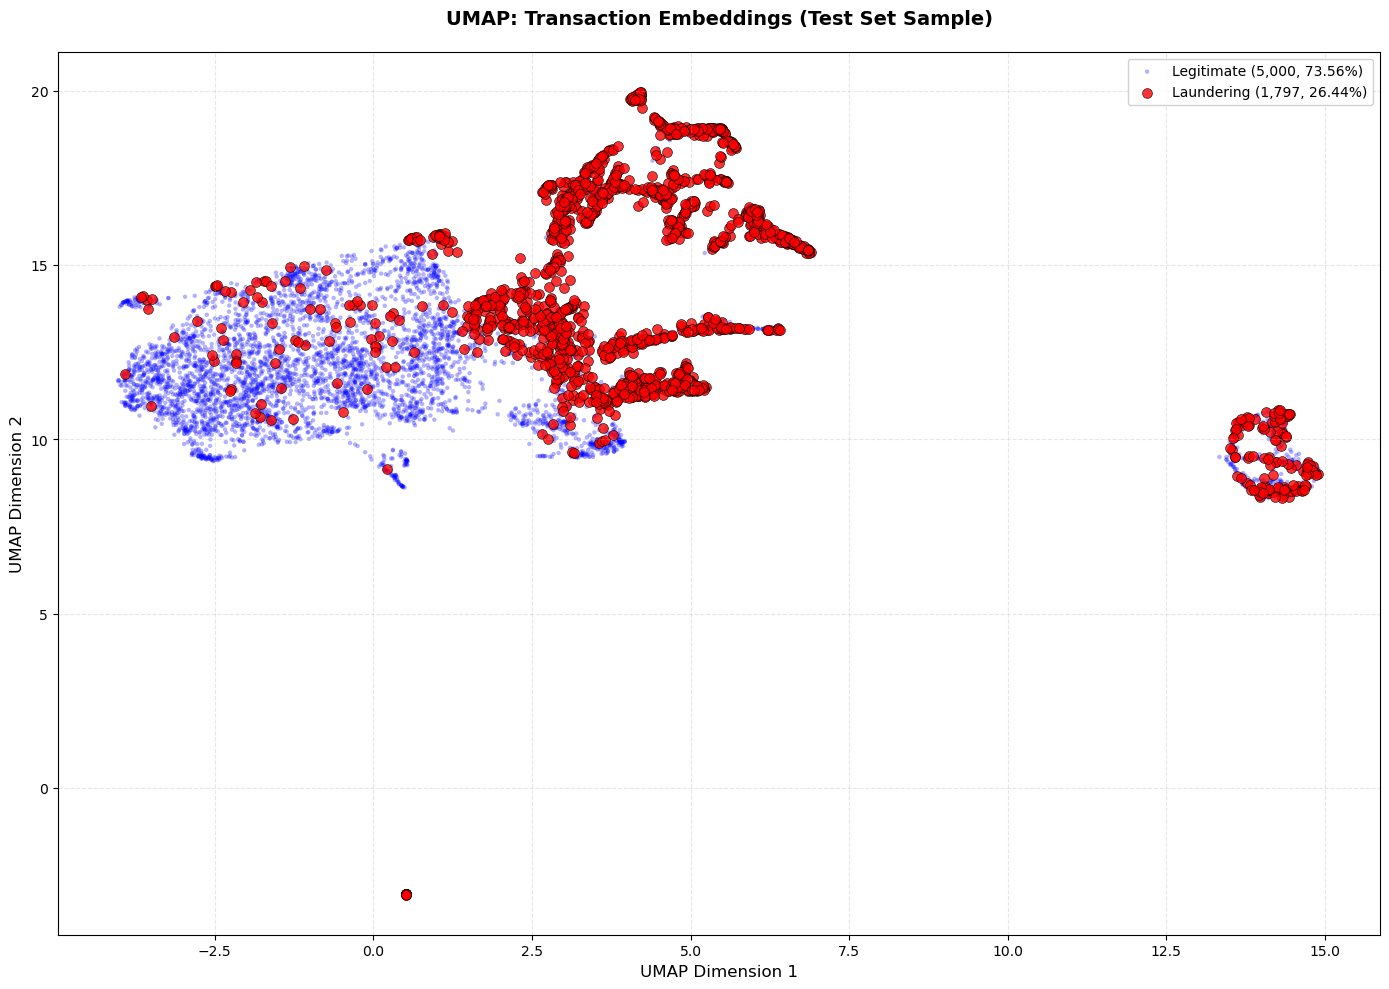

In [19]:
# Visualize UMAP embeddings with color-coding for laundering vs legitimate transactions

plot_umap_embeddings(
    umap_coords, 
    y_test_sample, 
    title="UMAP: Transaction Embeddings (Test Set Sample)",
    figsize=(14, 10)
)

In [20]:
# Compute separation metrics to quantify how well UMAP separates the classes

metrics = compute_umap_separation_metrics(umap_coords, y_test_sample)

UMAP SEPARATION DIAGNOSTICS

1. CLUSTERING QUALITY METRICS
--------------------------------------------------------------------------------
  Silhouette Score:        0.2810  (range: [-1, 1], higher = better separation)
  Davies-Bouldin Index:    1.6608  (lower = better separation)
  Calinski-Harabasz Score: 1106.64  (higher = better separation)

2. DISTANCE-BASED METRICS
--------------------------------------------------------------------------------
  Centroid Distance:           4.5298
  Avg Within-Class Distance:   3.7616
  Separation Ratio:            1.2042  (higher = better, >1 means clusters are separated)

3. 2D CLASSIFICATION PERFORMANCE (Logistic Regression on UMAP coords)
--------------------------------------------------------------------------------
  Confusion Matrix:
    [[TN= 817  FP= 183]
     [FN=  82  TP= 278]]

  Precision:  0.6030  (of predicted laundering, % actually laundering)
  Recall:     0.7722  (of actual laundering, % detected)
  F1 Score:   0.6772
  ROC-A

## 5. XGBoost Classifier on hand engineered features

In [21]:
# Import model training functions
from modules.model_training import *

# Extract labels for training and test sets
y_train = train_df['is_laundering'].values
y_test = test_df['is_laundering'].values

print(f"Training set: X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"Test set: X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")

Training set: X_train.shape=(4062676, 58), y_train.shape=(4062676,)
Test set: X_test.shape=(1015669, 58), y_test.shape=(1015669,)


In [22]:
# Free up memory before training XGBoost
import gc

del trans_df, train_df, test_df, test_sample, X_test_sample, accounts_df

del umap_coords, y_test_sample

gc.collect()

446530

In [23]:
# Create balanced training set by undersampling majority class

X_train_balanced, y_train_balanced = create_balanced_training_set(
    X_train, y_train,
    negative_to_positive_ratio=50,
    random_state=42
)

CREATING BALANCED TRAINING SET

Original Training Set:
  Laundering (positive): 3,380 (0.083%)
  Legitimate (negative): 4,059,296 (99.917%)
  Imbalance ratio: 1:1201

Balanced Training Set:
  Laundering (positive): 3,380 (1.96%)
  Legitimate (negative): 169,000 (98.04%)
  Imbalance ratio: 1:50
  Total samples: 172,380 (reduced from 4,062,676)
  Reduction: 95.8%



In [24]:
# Train XGBoost classifier on balanced training set

model, history = train_xgboost_classifier(
    X_train_balanced, y_train_balanced,
    validation_split=0.1,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=5
)

TRAINING XGBOOST CLASSIFIER

Training Set:
  Total samples: 155,142
  Legitimate: 152,100 (98.04%)
  Laundering: 3,042 (1.96%)
  Scale pos weight: 50.00

Validation Set:
  Total samples: 17,238
  Legitimate: 16,900
  Laundering: 338

Model Parameters:
  scale_pos_weight: 5
  learning_rate: 0.1
  max_depth: 6
  n_estimators: 100
  random_state: 42
  eval_metric: aucpr
  early_stopping_rounds: 10

Training...
[0]	validation_0-aucpr:0.50958
[1]	validation_0-aucpr:0.59462
[2]	validation_0-aucpr:0.60572
[3]	validation_0-aucpr:0.64537
[4]	validation_0-aucpr:0.65677
[5]	validation_0-aucpr:0.65192
[6]	validation_0-aucpr:0.66056
[7]	validation_0-aucpr:0.66653
[8]	validation_0-aucpr:0.67741
[9]	validation_0-aucpr:0.67761
[10]	validation_0-aucpr:0.67974
[11]	validation_0-aucpr:0.68148
[12]	validation_0-aucpr:0.68158
[13]	validation_0-aucpr:0.68177
[14]	validation_0-aucpr:0.68268
[15]	validation_0-aucpr:0.68301
[16]	validation_0-aucpr:0.68629
[17]	validation_0-aucpr:0.69126
[18]	validation_0-aucpr

In [25]:
# Evaluate XGBoost classifier on held-out test set

xgb_metrics = evaluate_classifier(model, X_test, y_test)

TEST SET EVALUATION

Test Set Size: 1,015,669
  Legitimate: 1,013,872 (99.82%)
  Laundering: 1,797 (0.18%)

Confusion Matrix:
                    Predicted
                      Legitimate    Laundering
  Actual Legitimate       972,537        41,335   (95.9% correct)
         Laundering           290         1,507   (83.9% correct)

Classification Metrics:
  Precision:      0.0352  (of predicted laundering, % actually laundering)
  Recall:         0.8386  (of actual laundering, % detected)
  F1 Score:       0.0675
  ROC-AUC:        0.9747
  PR-AUC:         0.2298 (best metric for imbalanced data)

Error Rates:
  False Positive Rate: 0.0408  (41,335 legitimate flagged as laundering)
  False Negative Rate: 0.1614  (290 laundering missed)



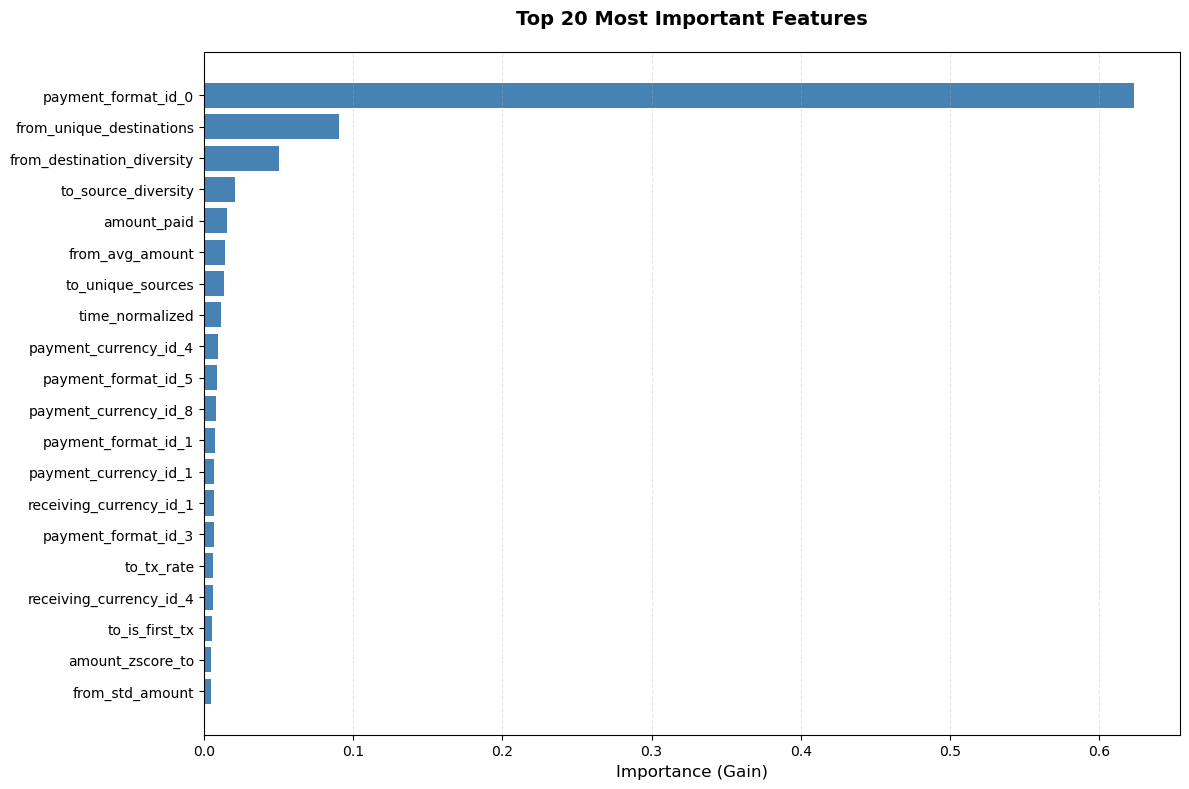

Top 20 Features:
                   feature  importance
       payment_format_id_0    0.623138
  from_unique_destinations    0.090755
from_destination_diversity    0.050105
       to_source_diversity    0.020694
               amount_paid    0.015258
           from_avg_amount    0.014122
         to_unique_sources    0.013368
           time_normalized    0.011393
     payment_currency_id_4    0.009455
       payment_format_id_5    0.008367
     payment_currency_id_8    0.007901
       payment_format_id_1    0.007017
     payment_currency_id_1    0.006696
   receiving_currency_id_1    0.006496
       payment_format_id_3    0.006313
                to_tx_rate    0.005761
   receiving_currency_id_4    0.005672
            to_is_first_tx    0.005034
          amount_zscore_to    0.004886
           from_std_amount    0.004767



In [26]:
# Analyze which features are most important for classification

importance_df = plot_feature_importance(model, feature_names, top_k=20)

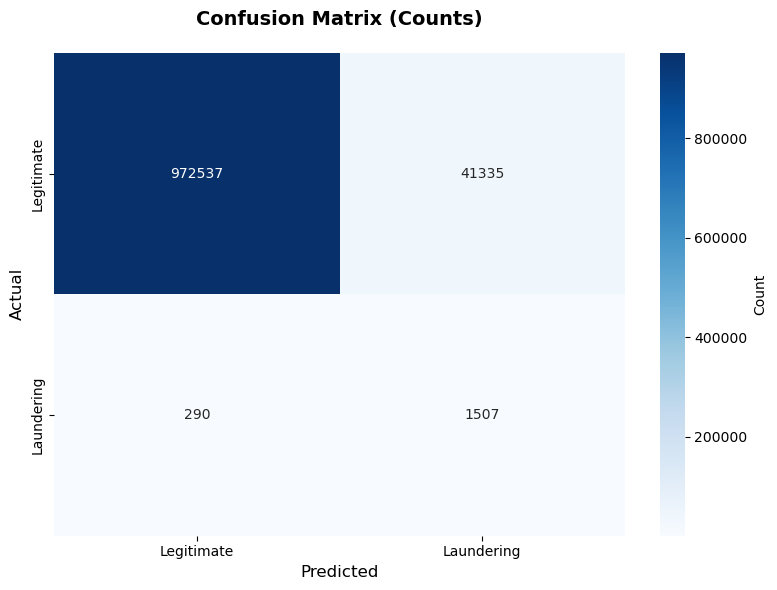

In [27]:
# Visualize confusion matrix as heatmap

plot_confusion_matrix_heatmap(
    xgb_metrics['confusion_matrix'],
    class_names=['Legitimate', 'Laundering'],
    normalize=False
)